In [1]:

import csv
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv

In [2]:
# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,5:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,5:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
error = energyDF[2:,3]
#print(exp)
# Construct a matrix containing the energy contributions from each Hamiltonian parameter to each nuclear state
E = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        if exp[i] <= 0:
            E[i,j] = energyDF[i+2,j+5]*backgroundHam[j]
            gsContributions = E[i,:]
        else:
            E[i,j] = energyDF[i+2,j+5]*backgroundHam[j] - gsContributions[j]
    print(E[i])
print(E)
#print(energyDF[2:,4])
#print(scipy.linalg.norm(energyDF[2:,4]-exp)/math.sqrt(len(exp)))

[-0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.
  0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0.  0.
  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0.
 -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.]
[-14.8508  -0.      -0.      -0.      -0.      -0.      -0.       0.
  -0.      -0.       0.       0.       0.      -0.       0.       0.
   0.       0.       0.      -0.      -0.      -0.       0.       0.
   0.       0.       0.      -0.       0.      -0.      -0.       0.
   0.       0.      -0.       0.       0.       0.      -0.       0.
   0.       0.       0.       0.      -0.       0.       0.       0.
   0.      -0.       0.       0.      -0.       0.      -0.       0.
   0.       0.       0.      -0.       0.       0.       0.       0.
   0.       0.       0.      -0.       0.    ]
[ 14.8508 -14.1949   0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0. 

In [3]:
# Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
pInit = np.empty(len(backgroundHam))
pInit.fill(1)                         # Initial Hamiltonian parameter weights are all 1 (unfitted)
e = np.empty(len(backgroundHam))
G = np.empty((len(backgroundHam),len(backgroundHam)))
for i in range(len(backgroundHam)):           # Contructing data vector (e)
    eTot = 0
    for k in range(len(exp)):
        eTot += (exp[k]*E[k,i])/(error[k]**2)
    e[i] = eTot
for i in range(len(backgroundHam)):           # Constructing design matrix (G)
    for j in range(len(backgroundHam)):
        gTot = 0
        for k in range(len(exp)):
            gTot += (E[k,i]*E[k,j])/(error[k]**2)
        G[i,j] = gTot

In [4]:
# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,pInit)

35 vlc eRMS = 0.10668635896838932  pRMS =  0.2727829836879009
full SVD eRMS = 0.06633197118757364  pRMS = 0.7476037601901895


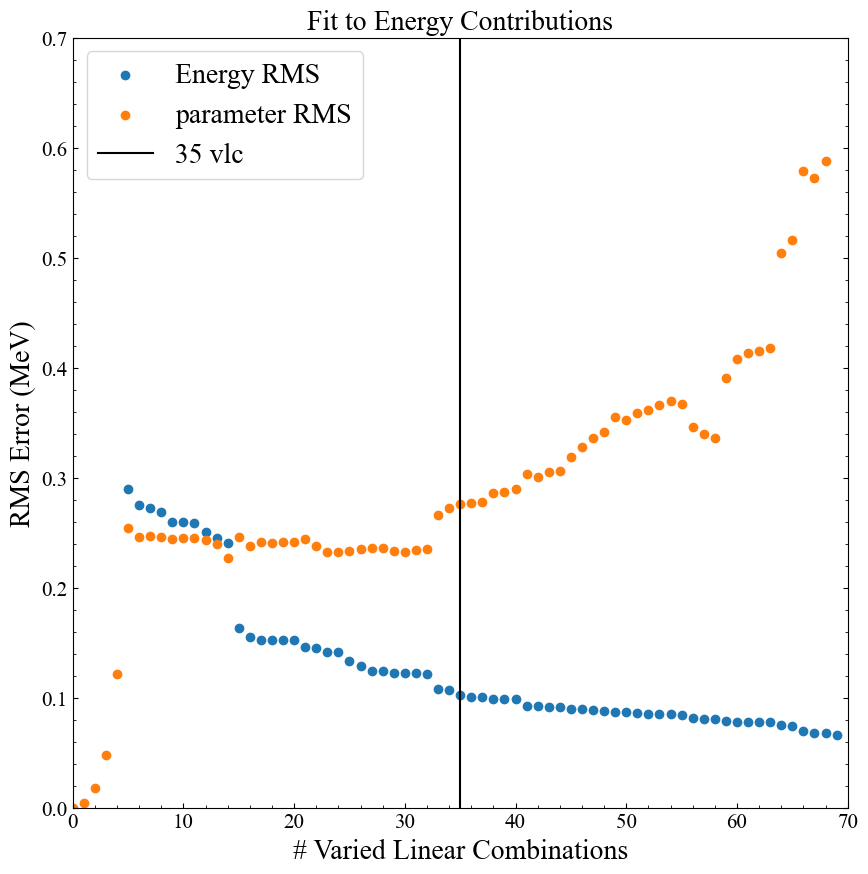

In [10]:
# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMS = np.empty(len(Svec)+1)
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    fitEnergies = np.empty(len(exp))                    # Array for storing fitted energies in this iteration
    eResidual = np.empty(0)                             # Array for storing residuals for RMS calculation
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    pfit = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(backgroundHam)):       
        fitParameters[j] = pfit[j]*backgroundHam[j] # Modify our initial fit parameters by the new weights in pfit
    for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
        if error[j] <= 1.0:
            eResidual = np.append(eResidual, exp[j]-eFitTot)
    pResidual = backgroundHam - fitParameters
    eRMS[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMS[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
print('35 vlc eRMS =', eRMS[34], ' pRMS = ', pRMS[34])
print('full SVD eRMS =', eRMS[69], ' pRMS =', pRMS[69])
x = [i for i in range(len(eRMS))]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x, eRMS, label='Energy RMS')
plt.scatter(x, pRMS, label='parameter RMS')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('Fit to Energy Contributions',fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(loc=2,fontsize=20)
plt.show()

In [8]:
Ginv = inv(G)
pfinal = np.dot(Ginv,e)
newHam = np.empty(len(backgroundHam))
for i in range(len(newHam)):
    newHam[i] = pfinal[i]*backgroundHam[i]
pRes = newHam-backgroundHam
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, eFitTot - exp[j])
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))
print(newHam-fittedHam)              # Difference between BAB Hamiltonian and my least squares


least squares energy RMS = 0.06633197118757364
least squares parameter RMS = 0.747603761225928
[-4.69412239e-02 -1.12413746e-01 -5.08784576e-02 -7.76481603e-02
 -6.85384514e-01 -2.53766656e-01 -7.82482149e-02 -2.01068045e+00
 -7.64869972e-02 -1.72587712e-01 -4.50661126e-01 -1.22382342e-01
  2.37534855e-02 -1.35284281e+00 -7.55938122e-01 -3.73666900e-01
  4.57878056e-02 -3.33558171e-01  4.53749222e-01 -2.78279080e-01
 -1.12330431e+00  1.16543972e+00 -1.92734835e+00 -1.87513078e-01
 -6.34745406e-01  7.71368634e-01 -8.51878364e-01 -3.68493041e-02
 -2.83779380e-01  8.41530065e-01 -5.66845654e-01 -2.74169100e-01
  9.46088723e-01  4.97097192e-02 -1.78709336e-01  8.20707743e-02
 -1.37391406e-02  3.08836922e-01 -3.21538825e-01  6.28023536e-01
  6.27691496e-01  1.79319327e-01 -2.38371433e-01  3.78254061e-01
 -1.04789552e-02 -8.76915156e-02  4.27540708e-01 -3.45611009e+00
 -1.84712911e-02 -5.33702657e-01 -3.79396491e-01  5.38117618e-01
  2.55109890e-01 -9.12677910e-02  1.07662776e-01  5.97135569

In [29]:
outputs1 = np.array([exp, error, energyDF[2:,4], fitEnergies, energyDF[2:,4]-fitEnergies])
outputs2 = np.array([fittedHam, newHam, newHam-fittedHam])

with open("outputs.dat","w") as f:
    f.write("Energy outputs   (0.189 MeV RMS for JP fit) \n")
    f.write("       exp      error        BAB         JP       Diff \n")
    np.savetxt(f, outputs1.T, delimiter=' ', fmt='%10.4f')
    f.write("Parameter outputs (0.616 MeV RMS for JP fit) \n")
    f.write("BAB    JP    Diff \n")
    np.savetxt(f, outputs2.T, delimiter=' ', fmt='%10.4f')
    f.write("\n")
    f.write("Elements of G: \n")
    np.savetxt(f, G, delimiter=' ', fmt='%15.4f')

In [11]:
# Least squares solution using numpy linalg as a check that my least squares solution agrees
newExp = np.empty(len(exp))
M = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    newExp[i] = exp[i]/error[i]
    for j in range(len(backgroundHam)):
        M[i,j] = E[i,j]/error[i]
lstSq = np.linalg.lstsq(M, newExp, rcond=None)

#print(lstSq[0])                    # This is the set of weights which minimizes least squares for the energy contributions
lsEnergy = np.empty(len(exp))
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += lstSq[0][k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, exp[j]-eFitTot)
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))

lsHam = np.empty(len(backgroundHam))
for i in range(len(lsHam)):
    lsHam[i] = lstSq[0][i]*backgroundHam[i]
pRes = lsHam-backgroundHam
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))
print(lsHam-fittedHam)                                  # Difference between BAB Hamiltonian and my least squares

least squares energy RMS = 0.06633197119046301
least squares parameter RMS = 0.7476037609756634
[-4.69412236e-02 -1.12413746e-01 -5.08784574e-02 -7.76481601e-02
 -6.85384517e-01 -2.53766655e-01 -7.82482161e-02 -2.01068045e+00
 -7.64869984e-02 -1.72587709e-01 -4.50661124e-01 -1.22382342e-01
  2.37534860e-02 -1.35284281e+00 -7.55938118e-01 -3.73666895e-01
  4.57878061e-02 -3.33558171e-01  4.53749223e-01 -2.78279081e-01
 -1.12330431e+00  1.16543972e+00 -1.92734836e+00 -1.87513076e-01
 -6.34745403e-01  7.71368633e-01 -8.51878361e-01 -3.68493019e-02
 -2.83779380e-01  8.41530061e-01 -5.66845651e-01 -2.74169099e-01
  9.46088725e-01  4.97097187e-02 -1.78709334e-01  8.20707749e-02
 -1.37391404e-02  3.08836921e-01 -3.21538825e-01  6.28023535e-01
  6.27691495e-01  1.79319327e-01 -2.38371432e-01  3.78254061e-01
 -1.04789554e-02 -8.76915158e-02  4.27540708e-01 -3.45611009e+00
 -1.84712913e-02 -5.33702657e-01 -3.79396492e-01  5.38117618e-01
  2.55109889e-01 -9.12677908e-02  1.07662776e-01  5.9713556